In [1]:
import pandas as pd
import numpy as np
import sqlite3
import yfinance as yf

# To Do!
The main goal of the next push is to get some causal discovery working.

* [ ] **Input Fetching Revamp**
    * [ ] Fetching more tickers from `yfinance`
    * [ ] Systematic loading and preparation of all tickers
    * [ ] Fetcher should not `dropna()` - that should happen in the loader
    * [ ] OOP?
* [ ] **Causal Discovery**

# Global Variables

In [2]:
start_date = "2000-01-01"
end_date = "2022-12-31"
tickers = [ "AAPL", "MSFT", "^GSPC", "GPW.WA", "MBK.WA", "ALE.WA" ]

# Input Fetching

In [3]:
prices = (yf.download(
    tickers=tickers,
    start=start_date, 
    end=end_date, 
    progress=False,
    group_by='ticker',
    period='1d'
  )
  .rename(columns={
    "Date": "date", 
    "Open": "open", 
    "High": "high",
    "Low": "low",
    "Close": "close", 
    "Adj Close": "adjusted", 
    "Volume": "volume"}
  )
)

l = [];
for ticker in tickers:
    l.append(prices[ticker].reset_index().assign(ticker=ticker))
merged = pd.concat(l).dropna()
del l

tidy_finance = sqlite3.connect(database="tidy_finance_python.sqlite")
merged.to_sql(name = "prices", con=tidy_finance, if_exists="replace", index=False)

26990

# Loading Data

In [4]:
apple_close = pd.read_sql_query(
  sql="SELECT close AS AAPL, date FROM prices WHERE ticker = 'AAPL'",
  con=tidy_finance,
  parse_dates={"date"}
).set_index('Date')
msft_close = pd.read_sql_query(
  sql="SELECT close AS MSFT, date FROM prices WHERE ticker = 'MSFT'",
  con=tidy_finance,
  parse_dates={"date"}
).set_index('Date')
spx_close = pd.read_sql_query(
  sql="SELECT close AS SPX, date FROM prices WHERE ticker = '^GSPC'",
  con=tidy_finance,
  parse_dates={"date"}
).set_index('Date')
gpw_close = pd.read_sql_query(
  sql="SELECT close AS GPW, date FROM prices WHERE ticker = 'GPW.WA'",
  con=tidy_finance,
  parse_dates={"date"}
).set_index('Date')
mbk_close = pd.read_sql_query(
  sql="SELECT close AS MBK, date FROM prices WHERE ticker = 'MBK.WA'",
  con=tidy_finance,
  parse_dates={"date"}
).set_index('Date')
ale_close = pd.read_sql_query(
  sql="SELECT close AS ALE, date FROM prices WHERE ticker = 'ALE.WA'",
  con=tidy_finance,
  parse_dates={"date"}
).set_index('Date')

# Random Garbage

Assume:

APPL -> MSFT -> SPX 

Then: causal effect of APPL on SPX is equal to the beta of SPX ~ APPL + MSFT (parents used as an adjustment set)


In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
apple_close

,AAPL
Date,
2000-01-03 00:00:00,0.999442
2000-01-04 00:00:00,0.915179
2000-01-05 00:00:00,0.928571
2000-01-06 00:00:00,0.848214
2000-01-07 00:00:00,0.888393
...,...
2022-12-23 00:00:00,131.860001
2022-12-27 00:00:00,130.029999
2022-12-28 00:00:00,126.040001


In [7]:
msft_close

,MSFT
Date,
2000-01-03 00:00:00,58.281250
2000-01-04 00:00:00,56.312500
2000-01-05 00:00:00,56.906250
2000-01-06 00:00:00,55.000000
2000-01-07 00:00:00,55.718750
...,...
2022-12-23 00:00:00,238.729996
2022-12-27 00:00:00,236.960007
2022-12-28 00:00:00,234.529999


In [8]:
X = pd.merge( apple_close, msft_close, on = 'Date', how='inner').dropna()
X.head()

,AAPL,MSFT
Date,,
2000-01-03 00:00:00,0.999442,58.28125
2000-01-04 00:00:00,0.915179,56.31250
2000-01-05 00:00:00,0.928571,56.90625
2000-01-06 00:00:00,0.848214,55.00000
2000-01-07 00:00:00,0.888393,55.71875


In [9]:
model = LinearRegression(fit_intercept=False).fit(X, spx_close.dropna())

In [10]:
print(model.coef_)

[[-36.06404095  37.18580826]]


Causal effect is -36?

<Axes: xlabel='Date'>

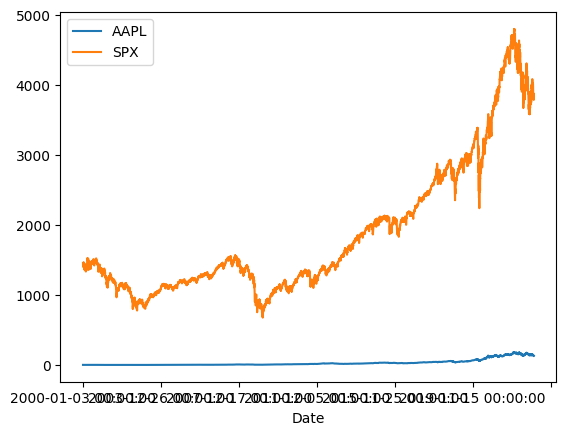

In [11]:
import matplotlib as plt

apple_close.join(spx_close).plot()

In [12]:
import statsmodels.api as sm
model2 = sm.OLS(spx_close, apple_close).fit()

#view model summary
print(model2.summary())

                                 OLS Regression Results                                
Dep. Variable:                    SPX   R-squared (uncentered):                   0.749
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                          1.729e+04
Date:                Thu, 02 May 2024   Prob (F-statistic):                        0.00
Time:                        22:40:20   Log-Likelihood:                         -48499.
No. Observations:                5787   AIC:                                  9.700e+04
Df Residuals:                    5786   BIC:                                  9.701e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [13]:
print(LinearRegression(fit_intercept=False).fit(msft_close, spx_close).coef_)

[[19.01065926]]


<Axes: xlabel='Date'>

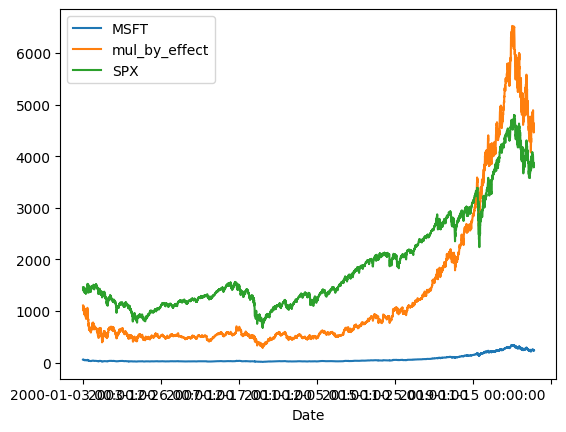

In [14]:
msft_close.assign(mul_by_effect=lambda x: x['MSFT'] * 19.01).join(spx_close).plot()

In [15]:
print(LinearRegression(fit_intercept=False).fit(msft_close, apple_close).coef_)

[[0.50396873]]


In [16]:
data = pd.merge(X, spx_close, on='Date', how='inner')
data.head()

,AAPL,MSFT,SPX
Date,,,
2000-01-03 00:00:00,0.999442,58.28125,1455.219971
2000-01-04 00:00:00,0.915179,56.31250,1399.420044
2000-01-05 00:00:00,0.928571,56.90625,1402.109985
2000-01-06 00:00:00,0.848214,55.00000,1403.449951
2000-01-07 00:00:00,0.888393,55.71875,1441.469971


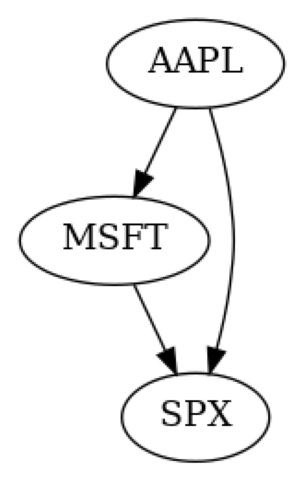

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter



import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)

model= CausalModel(data=data, common_causes='AAPL', treatment='MSFT', outcome='SPX')
model.view_model(layout="dot")

In [18]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                
───────(E[SPX|AAPL])
d[MSFT]             
Estimand assumption 1, Unconfoundedness: If U→{MSFT} and U→SPX then P(SPX|MSFT,AAPL,U) = P(SPX|MSFT,AAPL)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Causal Estimate is 5.232898071925774


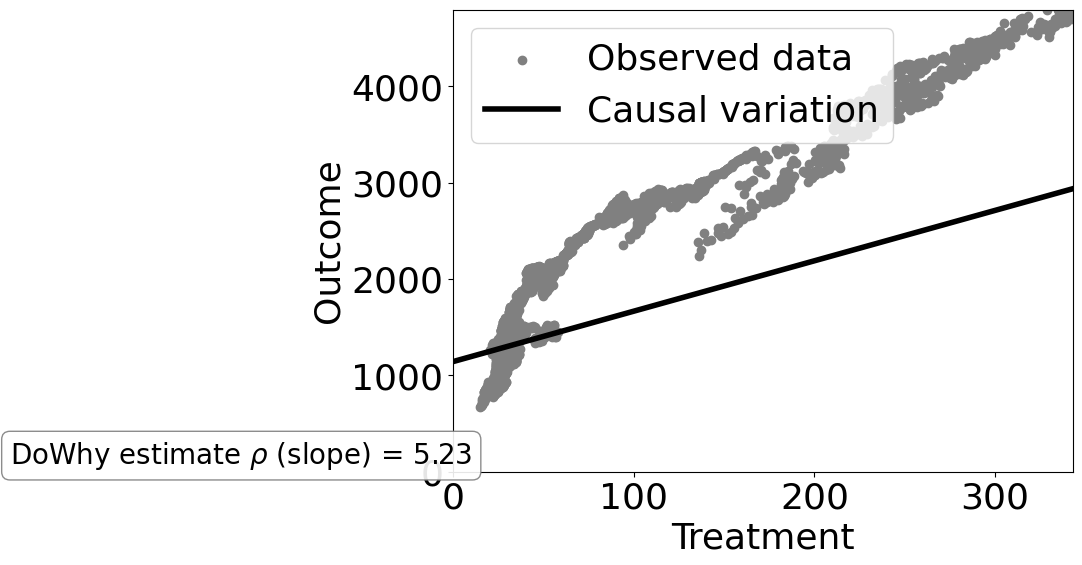

In [19]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, data['MSFT'], data['SPX'])

In [20]:
res_random=model.refute_estimate(estimand=identified_estimand, estimate=estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:5.232898071925774
New effect:5.233080162128797
p value:0.78



In [21]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:5.232898071925774
New effect:-0.003996977246483766
p value:0.84



In [22]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:5.232898071925774
New effect:5.233174282639441
p value:0.98



<Axes: xlabel='Date'>

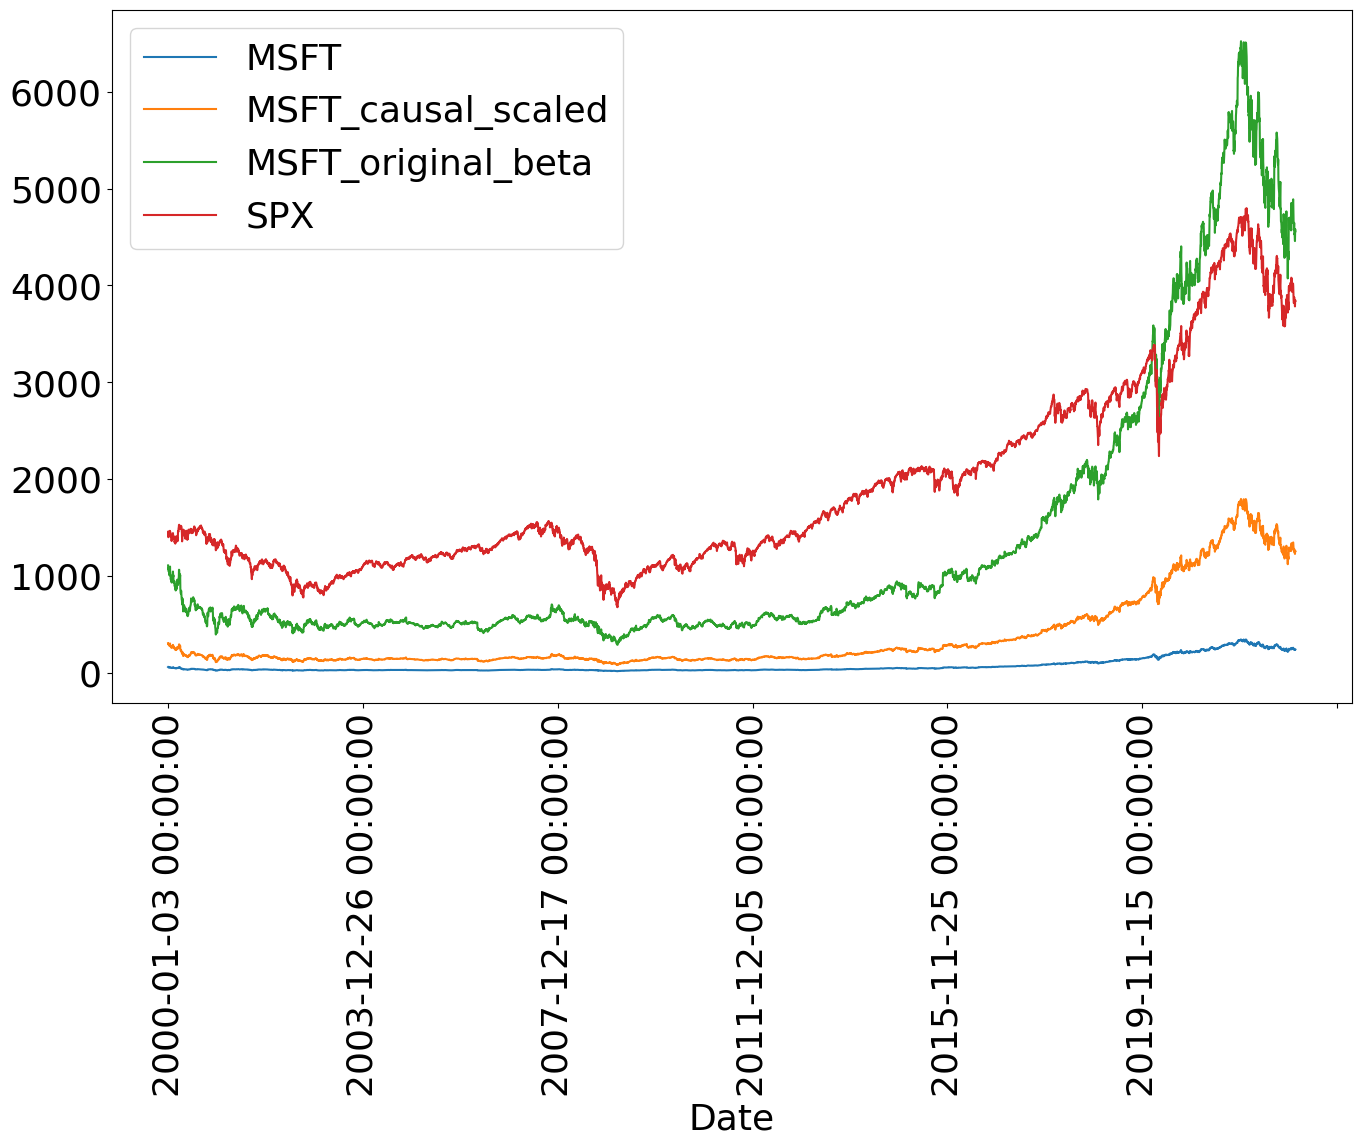

In [23]:
msft_close.assign(MSFT_causal_scaled=lambda x: x['MSFT'] * 5.23).assign(MSFT_original_beta = lambda x: x['MSFT']*19.01).join(spx_close).plot(figsize=(16,9), rot=90)

In [24]:
from dowhy import gcm

In [25]:
scm = gcm.StructuralCausalModel(model)
gcm.auto.assign_causal_mechanisms(scm, data)
gcm.fit(scm, data)

Fitting causal mechanism of node AAPL: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Test permutations of given graph: 100%|██████████| 6/6 [00:00<00:00, 1327.45it/s]
/usr/local/lib/python3.10/dist-packages/dowhy/gcm/falsify.py:727: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


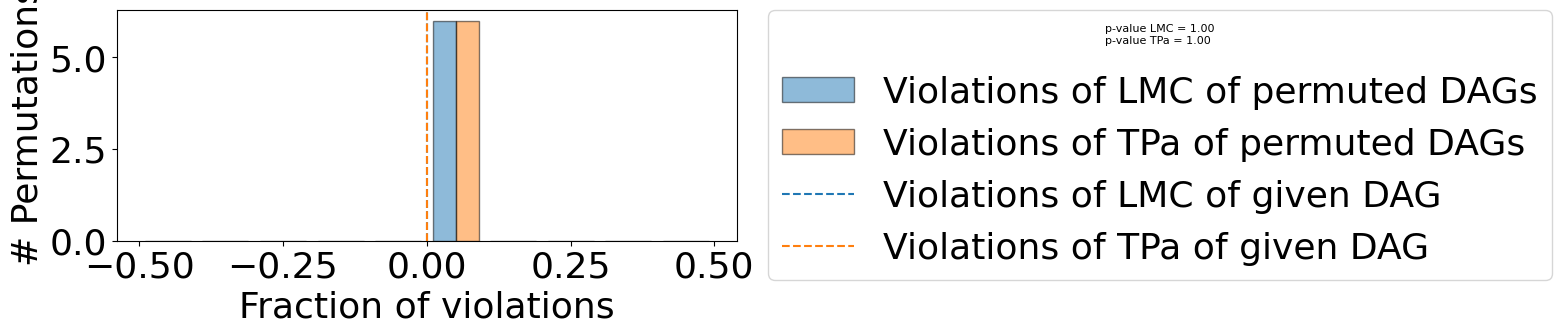

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [26]:
print(gcm.evaluate_causal_model(scm, data, evaluate_invertibility_assumptions=True, evaluate_causal_structure=True))

In [27]:
from dowhy.utils.plotting import plot, bar_plot

{('AAPL', 'SPX'): 170354.44197468515, ('MSFT', 'SPX'): 252813.56583857242}


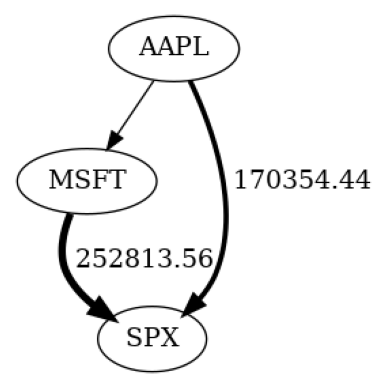

In [28]:
arrow_strengths_spx = gcm.arrow_strength(scm, target_node='SPX')
print(arrow_strengths_spx)
dowhy.utils.plotting.plot(scm.graph, causal_strengths=arrow_strengths_spx)

In [29]:
#strength_median, strength_intervals = gcm.confidence_intervals(
#    gcm.bootstrap_sampling(gcm.arrow_strength, scm,target_node='SPX'))
#strength_median, strength_intervals

strength_median, strength_intervals = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.arrow_strength, scm, bootstrap_training_data=data, target_node='SPX'),
    num_bootstrap_resamples=50,
    n_jobs=10,
)
strength_median, strength_intervals

Fitting causal mechanism of node AAPL: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


({('AAPL', 'SPX'): 150399.6258657997, ('MSFT', 'SPX'): 272155.8498815274},
 {('AAPL', 'SPX'): array([102987.14520652, 217700.90362036]),
  ('MSFT', 'SPX'): array([196320.45262818, 337950.63324043])})

In [30]:
iccs_spx = gcm.intrinsic_causal_influence(scm, target_node='SPX')

Evaluate set function: 8it [00:00, 23763.76it/s]


In [31]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

In [32]:
halving_msft = gcm.interventional_samples(scm,
                                        {'MSFT': lambda y: y/2 },
                                        num_samples_to_draw=1000)
halving_aapl = gcm.interventional_samples(scm,
                                        {'AAPL': lambda y: y/2 },
                                        num_samples_to_draw=1000)
print(f"Effect of halving all MSFT observations on average SPX: {data['SPX'].mean() - halving_msft['SPX'].mean()}")
print(f"Effect of halving all AAPL observations on average SPX: {data['AAPL'].mean() - halving_aapl['AAPL'].mean()}")

Effect of halving all MSFT observations on average SPX: 413.86946965071684
Effect of halving all AAPL observations on average SPX: 14.17490120966321


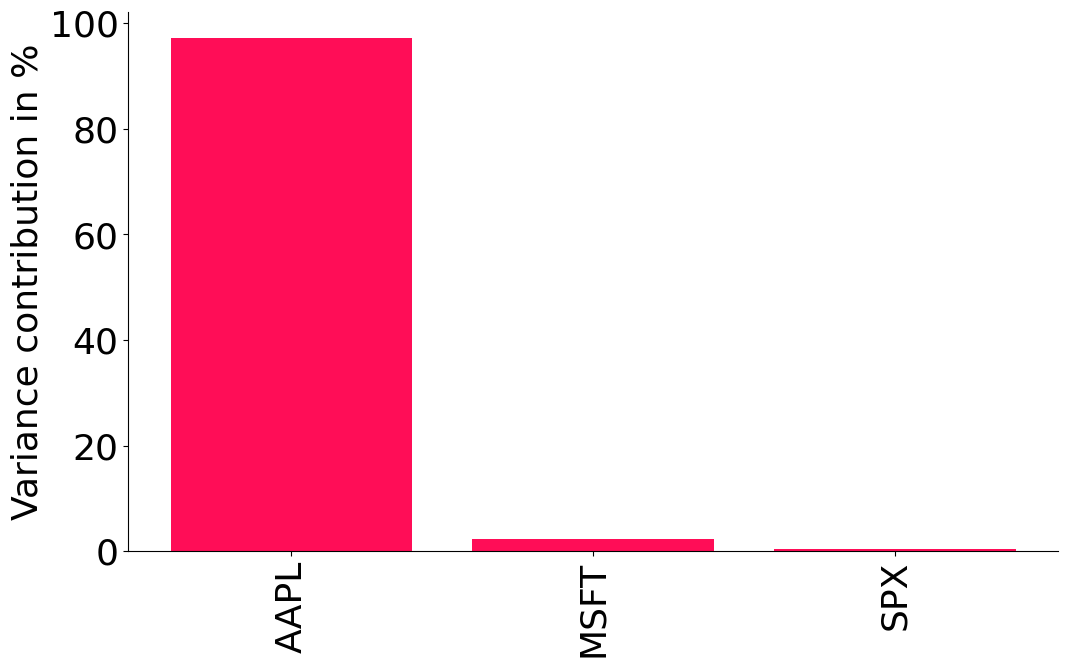

In [33]:
bar_plot(convert_to_percentage(iccs_spx), ylabel='Variance contribution in %', figure_size=(12,7))

In [34]:
data.head()
data.tail(15)

,AAPL,MSFT,SPX
Date,,,
2022-12-09 00:00:00,142.160004,245.419998,3934.379883
2022-12-12 00:00:00,144.490005,252.509995,3990.560059
2022-12-13 00:00:00,145.470001,256.920013,4019.649902
2022-12-14 00:00:00,143.210007,257.220001,3995.320068
2022-12-15 00:00:00,136.500000,249.009995,3895.750000
2022-12-16 00:00:00,134.509995,244.690002,3852.360107
2022-12-19 00:00:00,132.369995,240.449997,3817.659912
2022-12-20 00:00:00,132.300003,241.800003,3821.620117
2022-12-21 00:00:00,135.449997,244.429993,3878.439941


In [35]:
data.head()

,AAPL,MSFT,SPX
Date,,,
2000-01-03 00:00:00,0.999442,58.28125,1455.219971
2000-01-04 00:00:00,0.915179,56.31250,1399.420044
2000-01-05 00:00:00,0.928571,56.90625,1402.109985
2000-01-06 00:00:00,0.848214,55.00000,1403.449951
2000-01-07 00:00:00,0.888393,55.71875,1441.469971


In [36]:
logreturns = data.copy()
for ticker in data.columns:
    logreturns[ticker] = np.log1p(data[ticker].pct_change())

logreturns = logreturns.dropna()
logreturns.tail(10)

,AAPL,MSFT,SPX
Date,,,
2022-12-16 00:00:00,-0.014686,-0.017501,-0.011200
2022-12-19 00:00:00,-0.016038,-0.017480,-0.009048
2022-12-20 00:00:00,-0.000529,0.005599,0.001037
2022-12-21 00:00:00,0.023530,0.010818,0.014759
2022-12-22 00:00:00,-0.024060,-0.025860,-0.014557
2022-12-23 00:00:00,-0.002802,0.002265,0.005851
2022-12-27 00:00:00,-0.013976,-0.007442,-0.004058
2022-12-28 00:00:00,-0.031166,-0.010308,-0.012093
2022-12-29 00:00:00,0.027931,0.027255,0.017311


In [37]:
#logreturns.loc['2020-01-01': '2022-01-01'].tail()

In [38]:
logreturns_1w = logreturns.loc['2022-12-27' : '2022-12-31'] # data from the last week of observations (4 days)
logreturns_1m = logreturns.loc['2022-12-01' : '2022-12-27'] # data from the last month (december) but excluding the last week
logreturns_3m = logreturns.loc['2022-09-01' : '2022-12-01'] # data from last three months excluding the last month (and last week)
logreturns_6m = logreturns.loc['2022-06-01' : '2022-09-01'] # last 6m excluding last 3m 
logreturns_1y = logreturns.loc['2022-01-03' : '2022-06-01'] # similarly
logreturns_3y = logreturns.loc['2020-01-02' : '2022-01-03'] # similarly

array([[<Axes: title={'center': 'AAPL'}>,
        <Axes: title={'center': 'MSFT'}>],
       [<Axes: title={'center': 'SPX'}>, <Axes: >]], dtype=object)

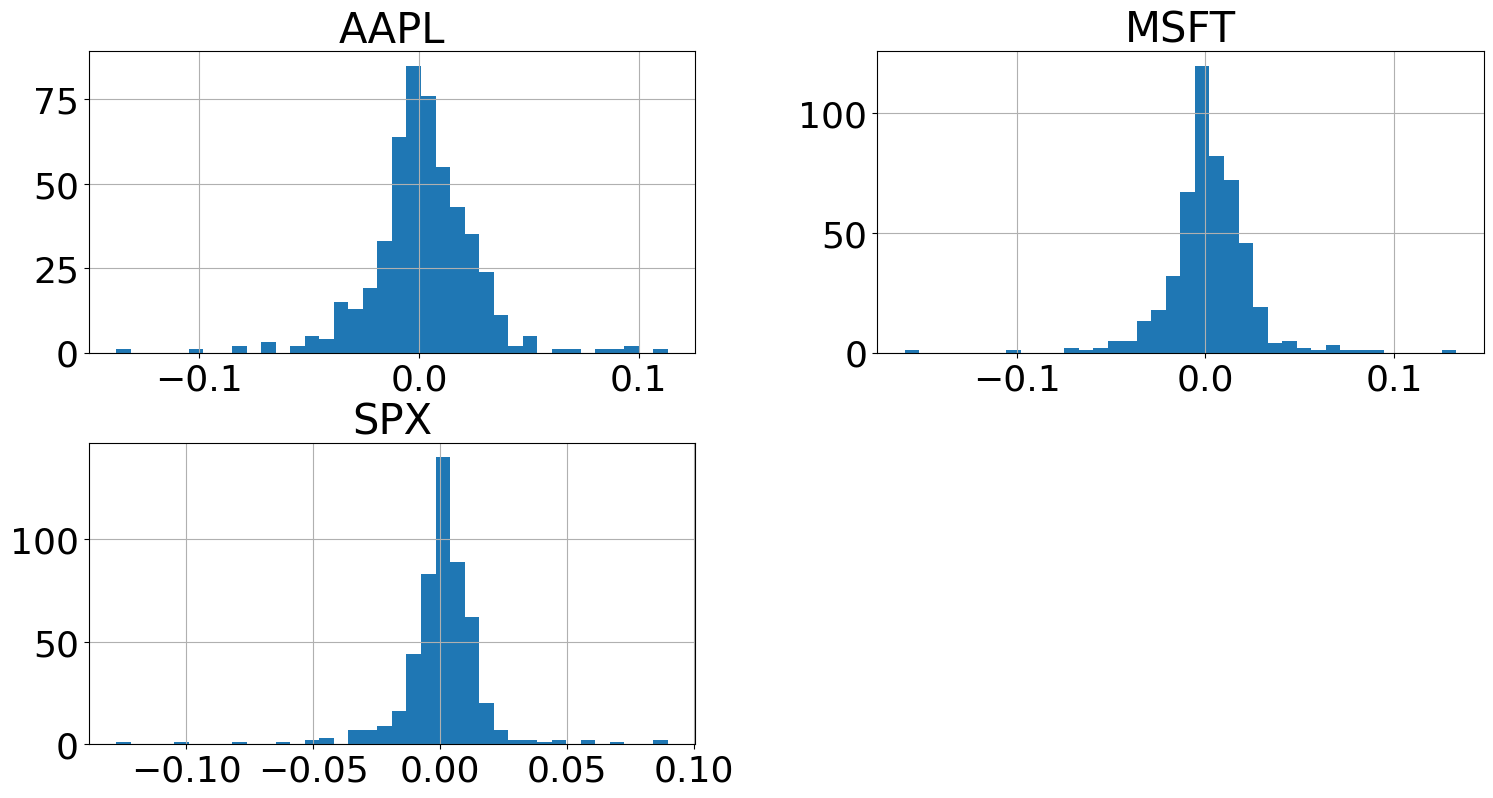

In [39]:
logreturns_3y.hist(bins=int(np.sqrt(logreturns_3y.size)), figsize=(18,9))

In [40]:
lrt_scm = gcm.StructuralCausalModel(model)
gcm.auto.assign_causal_mechanisms(lrt_scm, logreturns_3m)
gcm.fit(lrt_scm, logreturns_3m)

Fitting causal mechanism of node AAPL: 100%|██████████| 3/3 [00:00<00:00, 485.00it/s]


In [41]:
#print(gcm.evaluate_causal_model(lrt_scm, logreturns_3m, evaluate_invertibility_assumptions=False, evaluate_causal_structure=False))

In [42]:
iccs_lrt_3m = gcm.intrinsic_causal_influence(lrt_scm, target_node='SPX')

Evaluate set function: 8it [00:00, 28268.27it/s]


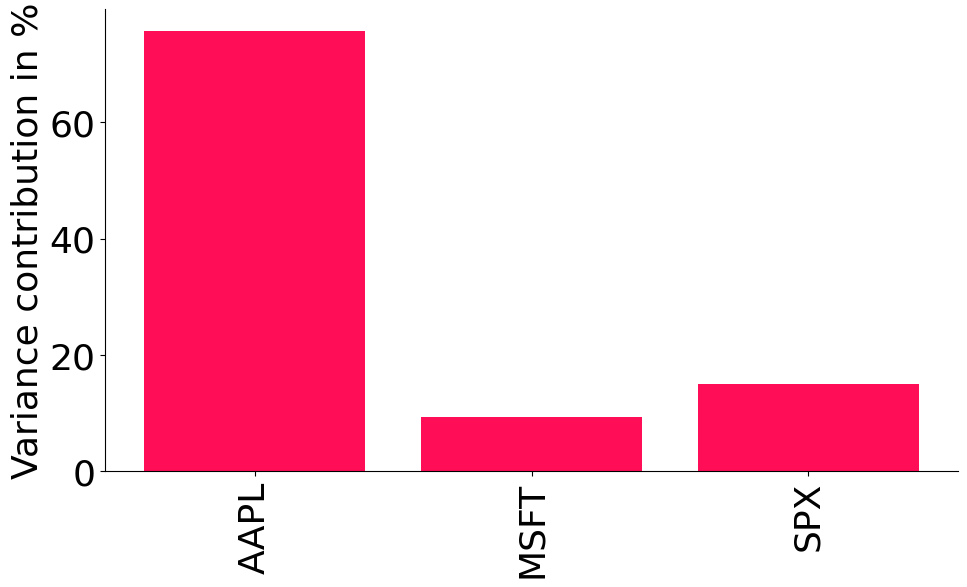

In [43]:
bar_plot(convert_to_percentage(iccs_lrt_3m), ylabel='Variance contribution in %', figure_size=(11,6))

In [44]:
# Merge into one dataset where columns represent the time period and rows are non-zero in each period only.
merged = data[[]] # just the index (dates)
frequency_lrs = {
    "1w" : logreturns_1w,
    "1m" : logreturns_1m,
    "3m" : logreturns_3m,
    "6m" : logreturns_6m,
    "1y" : logreturns_1y,
    "3y" : logreturns_3y,
}
frequency_lrs = {freq:df.rename(columns={col:col+freq for col in logreturns.columns}) for freq,df in frequency_lrs.items()}

for freq, df in frequency_lrs.items():
    merged = merged.join(df, how='left', on = 'Date')

merged = merged.fillna(0)
merged.tail(6)

,AAPL1w,MSFT1w,SPX1w,AAPL1m,MSFT1m,SPX1m,AAPL3m,MSFT3m,SPX3m,AAPL6m,MSFT6m,SPX6m,AAPL1y,MSFT1y,SPX1y,AAPL3y,MSFT3y,SPX3y
Date,,,,,,,,,,,,,,,,,,
2022-12-22 00:00:00,0.000000,0.000000,0.000000,-0.024060,-0.025860,-0.014557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-23 00:00:00,0.000000,0.000000,0.000000,-0.002802,0.002265,0.005851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-27 00:00:00,-0.013976,-0.007442,-0.004058,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-28 00:00:00,-0.031166,-0.010308,-0.012093,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-29 00:00:00,0.027931,0.027255,0.017311,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-30 00:00:00,0.002466,-0.004950,-0.002544,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
import networkx as nx

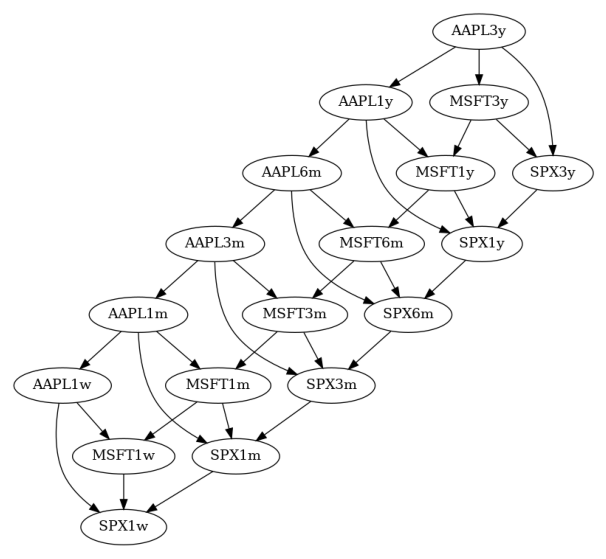

In [46]:
def freq_cols(freq:str, df):
    return [x for x in merged.columns if x.endswith(freq)]

edges = []
for posterior, prior in zip(list(frequency_lrs), list(frequency_lrs)[1:]):
    edges += [(cause,effect) for cause,effect in zip(freq_cols(prior, merged), freq_cols(posterior, merged))]
    edges += [('AAPL'+prior, 'MSFT'+prior)]
    edges += [('MSFT'+prior, 'SPX'+prior)]
    edges += [('AAPL'+prior, 'SPX'+prior)]

edges += [('AAPL1w', 'SPX1w'), ('AAPL1w', 'MSFT1w'), ('MSFT1w', 'SPX1w')]
graph = nx.DiGraph(edges)
general_model = gcm.StructuralCausalModel(graph)
gcm.util.plot(graph, figure_size=(11,7))

In [47]:
gcm.auto.assign_causal_mechanisms(general_model, merged)
gcm.fit(general_model, merged)

Fitting causal mechanism of node SPX3y: 100%|██████████| 18/18 [00:00<00:00, 103.74it/s]


In [48]:
print(gcm.evaluate_causal_model(general_model, merged, evaluate_invertibility_assumptions=False, evaluate_causal_structure=False))

Evaluating causal mechanisms...: 100%|██████████| 18/18 [00:00<00:00, 26649.30it/s]


Evaluated the performance of the causal mechanisms and the overall average KL divergence between generated and observed distribution. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the underlying classifier model.
- (normalized) Continuous Ranked Probability Score (CRPS):

In [49]:
iccs_general_spx1w = gcm.intrinsic_causal_influence(general_model, target_node='SPX1w')
iccs_general_spx1m = gcm.intrinsic_causal_influence(general_model, target_node='SPX1m')

Estimating Shapley Values. Average change of Shapley values in run 41 (205 evaluated permutations): 0.8892084673958985%: 100%|██████████| 1/1 [01:08<00:00, 68.34s/it]
Estimating Shapley Values. Average change of Shapley values in run 33 (165 evaluated permutations): 1.224055805363143%: 100%|██████████| 1/1 [00:36<00:00, 36.45s/it]


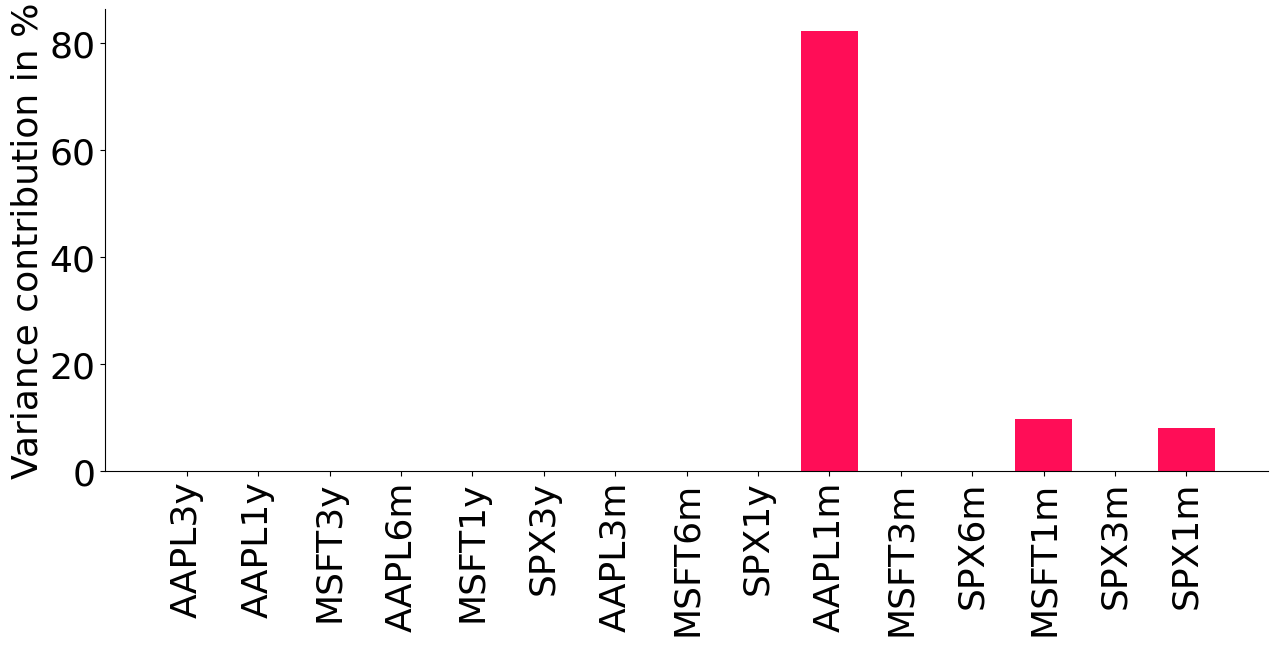

In [50]:
bar_plot(convert_to_percentage(iccs_general_spx1m), ylabel='Variance contribution in %', figure_size=(15,6))

In [51]:
strength_median, strength_intervals = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.arrow_strength, general_model, bootstrap_training_data=merged, target_node='SPX1m'),
    num_bootstrap_resamples=300,
    n_jobs=10,
)
strength_median, strength_intervals

Fitting causal mechanism of node SPX3y: 100%|██████████| 18/18 [00:00<00:00, 210.85it/s]


({('AAPL1m', 'SPX1m'): 5.624266996183007e-08,
  ('MSFT1m', 'SPX1m'): 1.5598244722288992e-07,
  ('SPX3m', 'SPX1m'): -1.8077271140058439e-09},
 {('AAPL1m', 'SPX1m'): array([1.10785025e-08, 1.22889635e-07]),
  ('MSFT1m', 'SPX1m'): array([5.82468072e-08, 2.64412876e-07]),
  ('SPX3m', 'SPX1m'): array([-3.97653752e-09,  3.89265559e-09])})

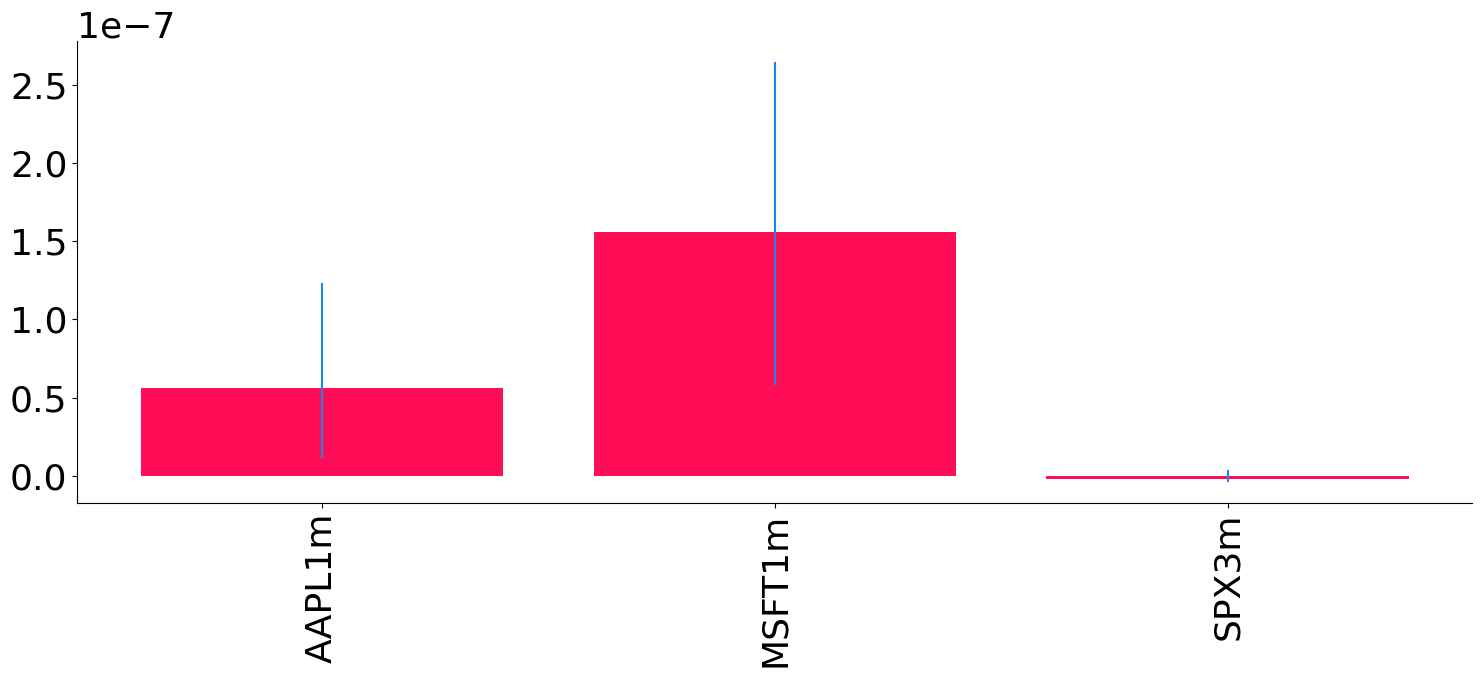

In [52]:
bar_plot({k[0]: v for k, v in strength_median.items()}, uncertainties={k[0]: v for k, v in strength_intervals.items()}, figure_size=(18,6))

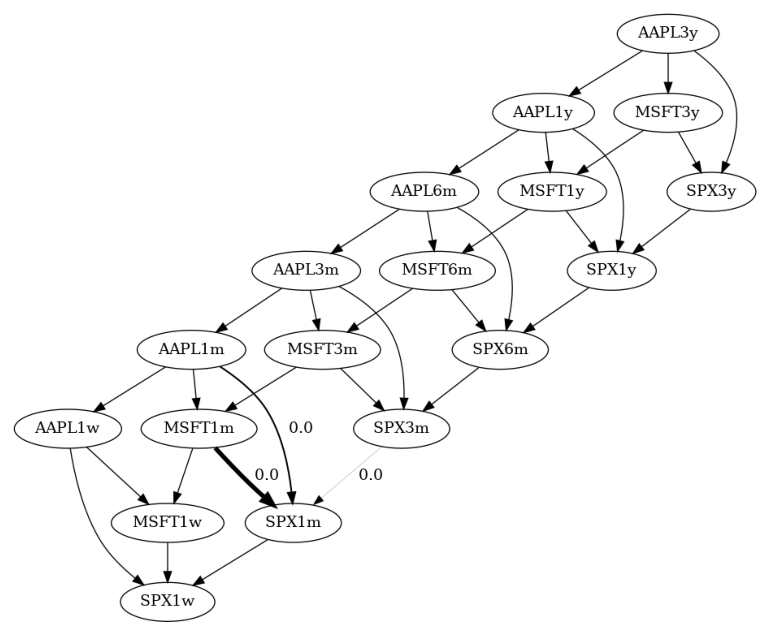

In [53]:
dowhy.utils.plotting.plot(general_model.graph, causal_strengths=strength_median, figure_size=(13,8))

Evaluate set function: 32it [00:00, 73867.76it/s]


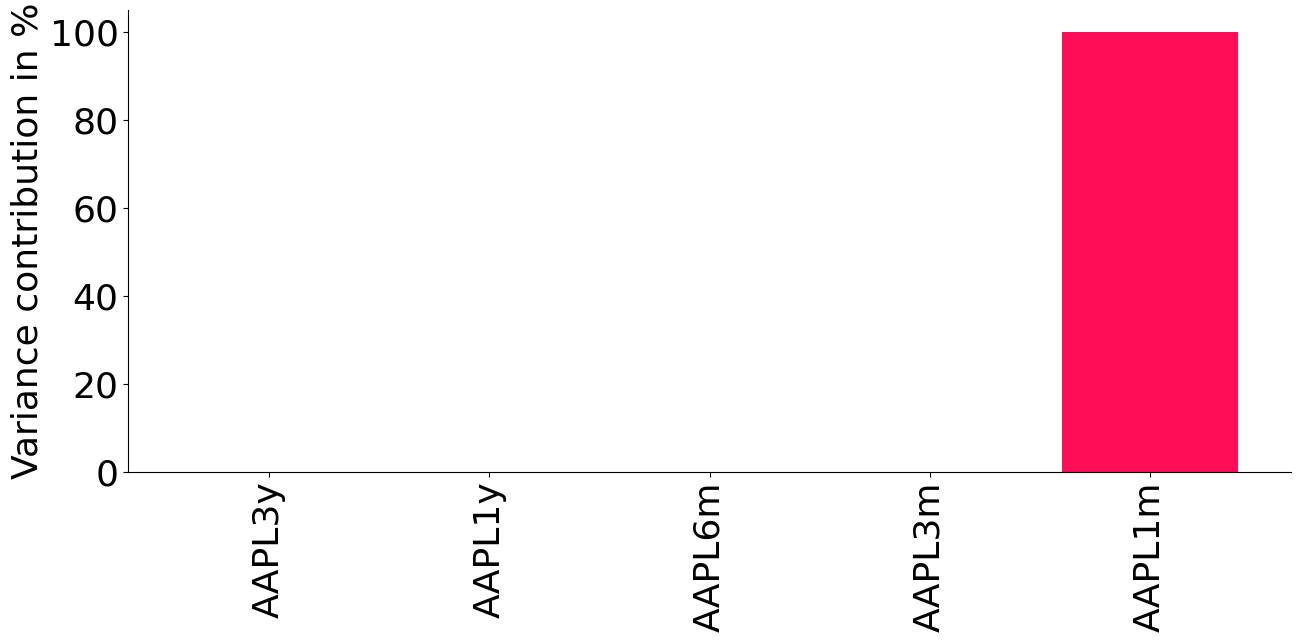

In [54]:
iccs_general_aapl1m = gcm.intrinsic_causal_influence(general_model, target_node='AAPL1m')
bar_plot(convert_to_percentage(iccs_general_aapl1m), ylabel='Variance contribution in %', figure_size=(15,6))

In [55]:
strength_median_aapl1m, strength_intervals_aapl1m = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.arrow_strength, general_model, bootstrap_training_data=merged, target_node='AAPL1m'),
    num_bootstrap_resamples=300,
    n_jobs=10,
)
strength_median_aapl1m, strength_intervals_aapl1m

Fitting causal mechanism of node SPX3y: 100%|██████████| 18/18 [00:00<00:00, 189.26it/s]


({('AAPL3m', 'AAPL1m'): -5.3655955589753336e-11},
 {('AAPL3m', 'AAPL1m'): array([-1.53311871e-07,  1.50805815e-07])})

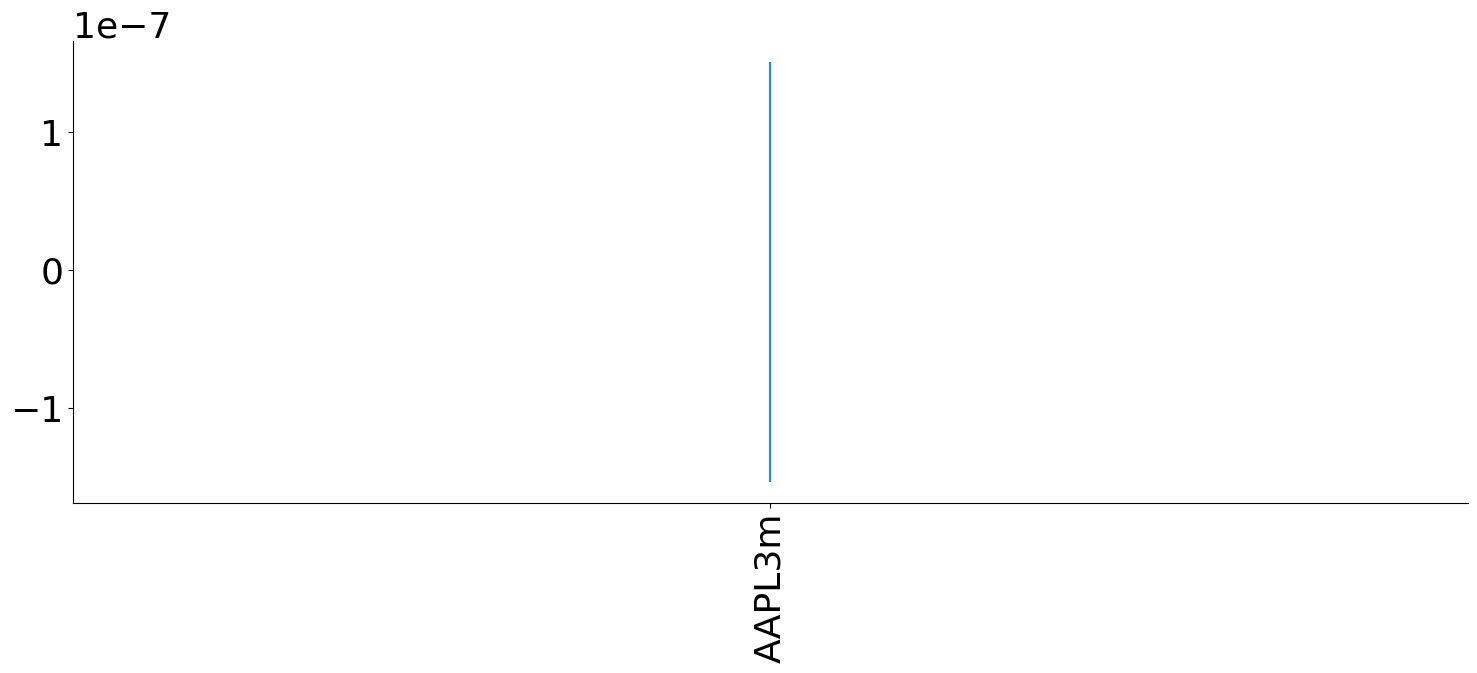

In [56]:
bar_plot({k[0]: v for k, v in strength_median_aapl1m.items()}, uncertainties={k[0]: v for k, v in strength_intervals_aapl1m.items()}, figure_size=(18,6))

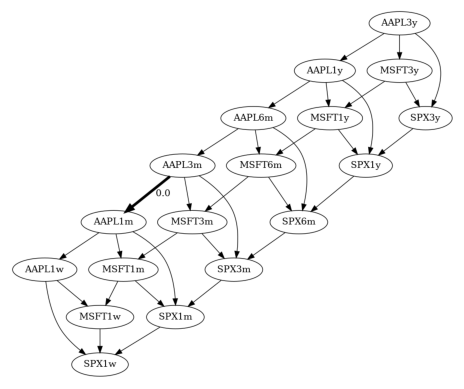

In [57]:
dowhy.utils.plotting.plot(general_model.graph, causal_strengths=strength_median_aapl1m)

In [58]:
window_length_days = 30
new_data = pd.merge( apple_close, msft_close, on = 'Date', how='inner')
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on='Date', how='inner'), [ apple_close, msft_close, spx_close, mbk_close, gpw_close, ale_close ] ).dropna()
df_merged.tail()

,AAPL,MSFT,SPX,MBK,GPW,ALE
Date,,,,,,
2022-12-23 00:00:00,131.860001,238.729996,3844.820068,300.000000,35.139999,25.379999
2022-12-27 00:00:00,130.029999,236.960007,3829.250000,287.000000,34.400002,24.830000
2022-12-28 00:00:00,126.040001,234.529999,3783.219971,293.000000,34.500000,24.889999
2022-12-29 00:00:00,129.610001,241.009995,3849.280029,296.799988,35.099998,25.514999
2022-12-30 00:00:00,129.929993,239.820007,3839.500000,296.000000,35.520000,25.129999


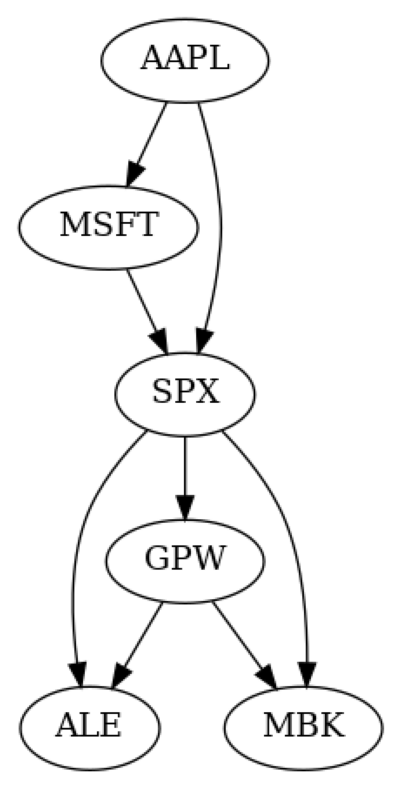

In [59]:
edges = [("MSFT", "SPX"), ("AAPL", "SPX"), ("AAPL", "MSFT"), ("SPX", "GPW"), ("GPW", "ALE"), ("GPW", "MBK"), ("SPX", "ALE"), ("SPX", "MBK")]
graph = nx.DiGraph(edges)
us_pl_model = gcm.StructuralCausalModel(graph)
gcm.util.plot(graph, figure_size=(16,10))

In [60]:
start   = '2022-10-10'
end     = '2022-11-30'
target_ticker = "ALE"
var_contribs = {}
for r in df_merged[start:end].rolling(window_length_days):
    if( len(r) != window_length_days ):
        continue
    us_pl_model = gcm.StructuralCausalModel(graph)
    gcm.auto.assign_causal_mechanisms(us_pl_model, r)
    gcm.fit(us_pl_model, r)
    ici = gcm.intrinsic_causal_influence(us_pl_model, target_node=target_ticker)
    current_contrib = convert_to_percentage(ici)
    var_contribs[ ( r.index[0], r.index[-1] ) ] = current_contrib
    

Fitting causal mechanism of node MBK: 100%|██████████| 6/6 [00:00<00:00, 499.88it/s]
Evaluate set function: 32it [00:00, 34753.43it/s]
Fitting causal mechanism of node MBK: 100%|██████████| 6/6 [00:00<00:00, 521.19it/s]
Evaluate set function: 32it [00:00, 92755.86it/s]
Fitting causal mechanism of node MBK: 100%|██████████| 6/6 [00:00<00:00, 985.43it/s]
Evaluate set function: 32it [00:00, 71278.67it/s]
Fitting causal mechanism of node MBK: 100%|██████████| 6/6 [00:00<00:00, 536.76it/s]
Evaluate set function: 32it [00:00, 91180.52it/s]
Fitting causal mechanism of node MBK: 100%|██████████| 6/6 [00:00<00:00, 460.17it/s]
Evaluate set function: 32it [00:00, 41956.15it/s]


In [61]:
var_contribs

{('2022-10-10 00:00:00', '2022-11-22 00:00:00'): {'AAPL': 34.527595791755274,
  'MSFT': 0.38214127722340535,
  'SPX': 31.6431541381777,
  'GPW': 22.747526544906044,
  'ALE': 10.699582247937567},
 ('2022-10-11 00:00:00', '2022-11-23 00:00:00'): {'AAPL': 32.92349346811284,
  'MSFT': 0.645511330291985,
  'SPX': 28.57896749938244,
  'GPW': 25.19473403957167,
  'ALE': 12.657293662641067},
 ('2022-10-12 00:00:00', '2022-11-25 00:00:00'): {'AAPL': 31.198924891556523,
  'MSFT': 1.674149369781397,
  'SPX': 29.734486334097138,
  'GPW': 23.942102123855484,
  'ALE': 13.450337280709462},
 ('2022-10-13 00:00:00', '2022-11-28 00:00:00'): {'AAPL': 22.07150944551132,
  'MSFT': 1.5354939300863248,
  'SPX': 33.282423238336825,
  'GPW': 28.660638701936776,
  'ALE': 14.44993468412876},
 ('2022-10-14 00:00:00', '2022-11-29 00:00:00'): {'AAPL': 19.06878856806578,
  'MSFT': 3.431010045355439,
  'SPX': 31.89880559885455,
  'GPW': 32.95587030530437,
  'ALE': 12.645525482419865}}

In [62]:
plot_data = {k: list() for k in list(var_contribs.values())[0].keys()}
for key, elem in var_contribs.items():
    for ticker, contribution in elem.items():
        plot_data[ticker].append( contribution )

In [63]:
spx_supplement = spx_close.rename(columns={'SPX': 'SPX-close'}) / 100
aapl_supplement = apple_close.rename(columns={'AAPL': 'AAPL-close '}) / 10
msft_supplement = msft_close.rename(columns={'MSFT': 'MSFT-close '}) / 10

<Axes: >

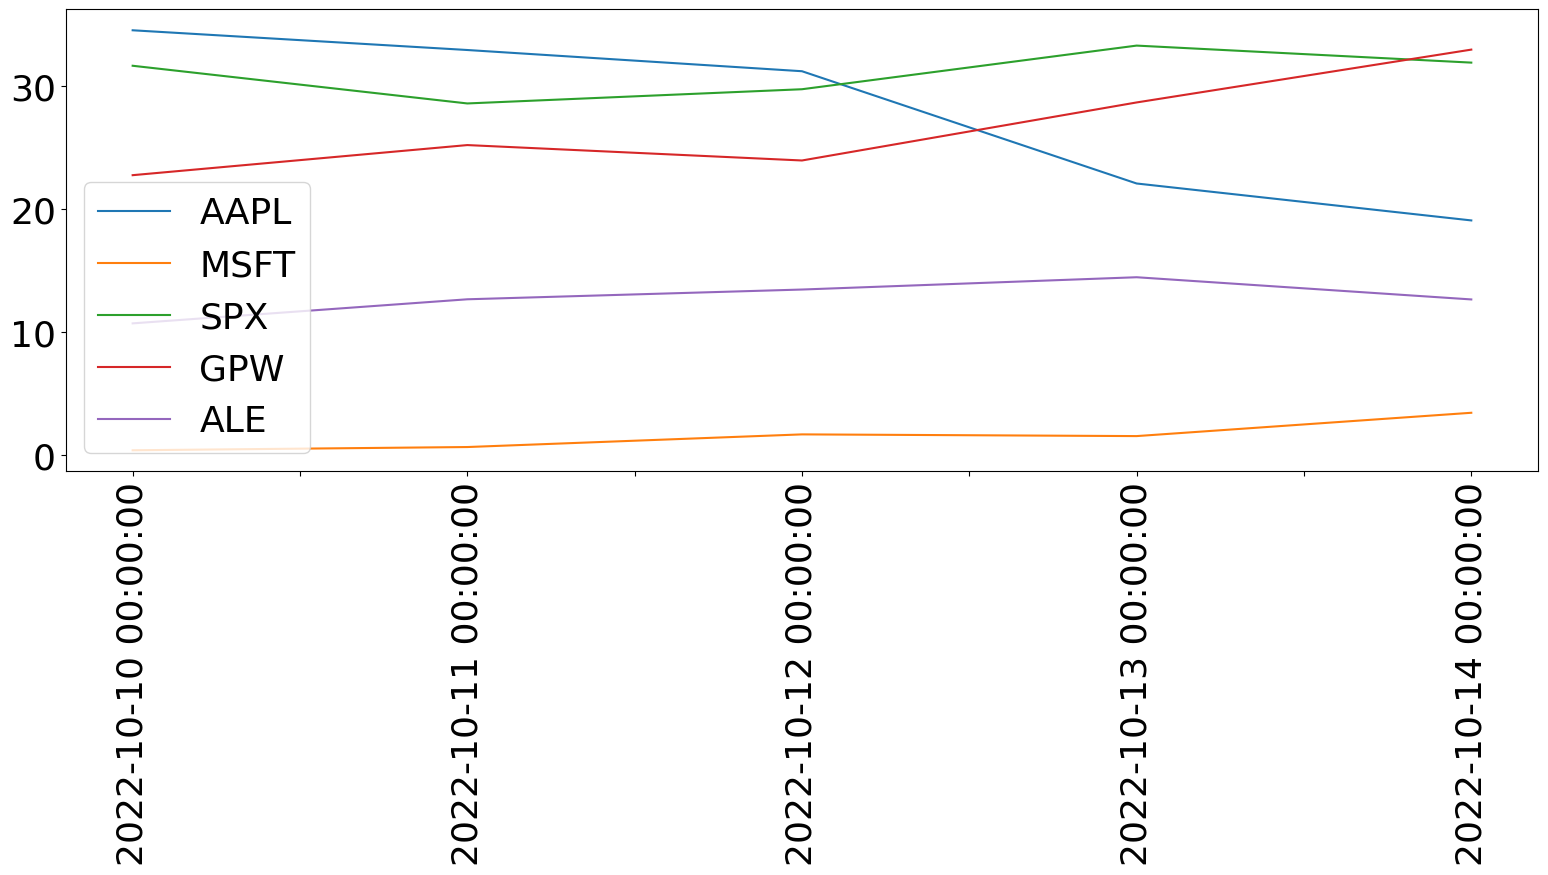

In [64]:
var_contribs_over_time = pd.DataFrame(plot_data, index=[k[0] for k in var_contribs.keys()])
#var_contribs_over_time=var_contribs_over_time.join(spx_supplement, how='left')
#var_contribs_over_time=var_contribs_over_time.join(aapl_supplement, how='left')
#var_contribs_over_time=var_contribs_over_time.join(msft_supplement, how='left')
var_contribs_over_time.plot(figsize=(19,6), rot=90)